# Instrument classifer

To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [1]:
from fastbook import *
from fastai.vision.widgets import *

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', 'key')

Next lets define the instruments types and determinate a path to store the images dowloaded

In [3]:
instrument_types = 'guitar','piano','trumpet'
path = Path('instruments')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in instrument_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('contentUrl'))

Its important that the we do not get corrupted images, so lets verify and clean the images unsing Path.unlink

In [7]:
fns = get_image_files(path)
fns

(#426) [Path('instruments/guitar/00f26183-0a2c-4214-8681-9b46eac0ad73.jpg'),Path('instruments/guitar/02f7dba8-27e9-4916-b453-6544bfc573fa.jpg'),Path('instruments/guitar/04d06265-0b60-45e5-a801-3bb7aa927033.jpg'),Path('instruments/guitar/0eac5f94-a765-4c0f-b244-f223d3bf5bfc.jpg'),Path('instruments/guitar/0fd824fa-524b-4eae-b595-6a106488338b.jpg'),Path('instruments/guitar/112d3f29-29d0-468c-9332-c14008bbca1c.jpg'),Path('instruments/guitar/1246c4c0-8284-465b-868b-d773b9f614d4.jpg'),Path('instruments/guitar/1263a2e3-d8dd-42e4-bd49-d5b241a20ea5.jpg'),Path('instruments/guitar/12fcb465-f2d5-4cb4-812b-2656ff822326.jpg'),Path('instruments/guitar/15ab45f7-2e1c-4371-bf7a-645047f615e7.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#5) [Path('instruments/guitar/2c10a594-18d4-4d3c-805a-521d1987e032.jpg'),Path('instruments/piano/4a3150e6-6557-408a-9bf8-c80733e4adac.jpg'),Path('instruments/piano/5281397c-e562-4a84-80cc-0f15a3b35fc2.jpg'),Path('instruments/piano/6f646d36-dbf7-488c-8691-942e591a7312.jpg'),Path('instruments/trumpet/0d3294dc-f85e-4725-8164-c96b34de6787.jpg')]

In [9]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

Now lets train our model with some configuration, first we transform the itens by cropping them with minimal values defined, and we also uses data augmentation techniques to diversify the images

In [11]:
instruments = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
instruments = instruments.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = instruments.dataloaders(path)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\gatos\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gatos\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.421016,0.038399,0.011905,01:01


C:\Users\gatos\miniconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.114775,0.005989,0.000000,00:51
1,0.100911,0.001102,0.000000,00:48
2,0.067131,0.001219,0.000000,00:48
3,0.050774,0.001551,0.000000,00:49


Now we need to check all missing images and ensure that nothing is wrong with the image labels, first we will take a look on the confusion matrix, after we will show all images with the most loss values

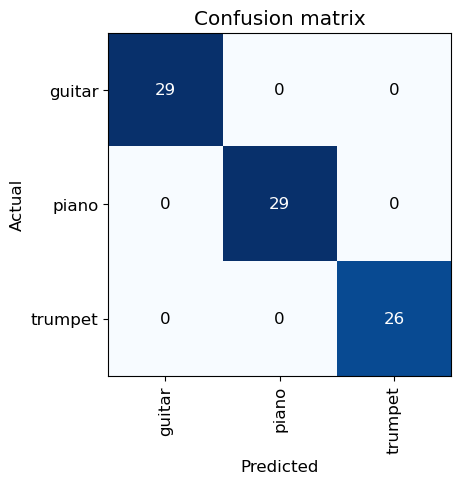

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

Now, lets export our model to use it on some application

In [15]:
learn.export()